# Viral load analysis

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-08-25 19:23:19.114346
Simons Foundation, Rusty HPC, worker3142


In [2]:
%cd /mnt/home/zzhang/ceph/jemm 
%run notebook/navy_utils_sexDiff.py data-V9

/mnt/ceph/users/zzhang/jemm
navy_utils_sexDiff.py data-V9 [] False


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.anova import anova_lm
import os

WD = "./data-V9/viral_reg"
os.makedirs(WD, exist_ok=True)

# Read in Metadata

In [4]:
# Read CT data
data = pd.read_table('./data-V9/charm_master.csv', low_memory=False)
#data = data[data.final.isin(('First', 'Mid', 'Post'))]
data['CTavg'] = data.apply(lambda x: x[['Nm.N.gene', 'Nm.S.gene', 'Nm.ORF1ab']].mean(), axis=1)

data['dayssinceinfect'] = data.groupby('pid')['tp'].transform('min')
data['dayssinceinfect'] = data['tp'] - data['dayssinceinfect']

data = data[['sid', 'pid', 'RNAseq_plate', 'final', 'Sex', 'Age', 'tp', 'dayssinceinfect', 'CTavg', 'virus_subCL', 
             'T0_date', 'Symptom', 'MS2']]

data['T0_date'] = pd.to_datetime(data['T0_date'])
data['samp_date'] = [data.iloc[i]['T0_date'] + pd.DateOffset(days=int(data.iloc[i]['tp'])) for i in range(data.shape[0])]
data['samp_month'] = [str(x) for x in data['samp_date'].dt.to_period('M')]
data['Symptom'].replace({np.nan: 'asymp'}, inplace=True)
data['is_asymp'] = data['Symptom'] == "asymp"
data['is_asymp'].replace({True: 'asymp', False: 'symp'}, inplace=True)
data['samp_month'].replace({'2020-05': '2020-06'}, inplace=True)
data['is_lab24'] = [pd.notna(x) for x in data['MS2']]
data.drop(columns=['MS2'], inplace=True)
data.index = data.sid

In [5]:
# exclude seropos

sero_pos = pd.read_table('data-V7.p1/merged_seropos.20210814.txt', index_col=0)
data = data[data.pid.isin(sero_pos.query('fz_label=="keep"').pid)]
print(data.shape)

(16985, 16)


In [6]:
data.head()

,sid,pid,RNAseq_plate,final,Sex,Age,tp,dayssinceinfect,CTavg,virus_subCL,T0_date,Symptom,samp_date,samp_month,is_asymp,is_lab24
sid,,,,,,,,,,,,,,,,
20_0149-T00,20_0149-T00,149,P3,Control,M,19.0,0,0,NaN,NaN,2020-05-11,asymp,2020-05-11,2020-06,asymp,False
20_0149-T07,20_0149-T07,149,NaN,Control,M,19.0,7,7,NaN,NaN,2020-05-11,asymp,2020-05-18,2020-06,asymp,False
20_0149-T14,20_0149-T14,149,NaN,Control,M,19.0,14,14,NaN,NaN,2020-05-11,asymp,2020-05-25,2020-06,asymp,False
20_0149-T28,20_0149-T28,149,P8,Pre,M,19.0,28,28,NaN,NaN,2020-05-11,asymp,2020-06-08,2020-06,asymp,False
20_0149-T42,20_0149-T42,149,NaN,First,M,19.0,42,42,29.9575,NaN,2020-05-11,asymp,2020-06-22,2020-06,asymp,True


In [7]:
print(data.query('Sex=="F"').shape)
print(data.query('Sex=="F"')['RNAseq_plate'].dropna().shape)
print(data.query('Sex=="M"').shape)
print(data.query('Sex=="M"')['RNAseq_plate'].dropna().shape)

(1528, 16)
(222,)
(15457, 16)
(1248,)


In [8]:
# Get sampling rate for Male and Females

def get_sampling_rate(dd):
    if dd.shape[0] == 1:
        return np.nan
    dd = dd.sort_values('tp', ascending=True)
    tp = dd['tp'].to_numpy()
    return np.mean(tp[1:] - tp[0:-1] )


df=pd.read_table('data-V9/charm_master.csv')
df = df[df['final'].isin(['Pre', 'First', 'Mid'])]

rate_f = [(d[0], get_sampling_rate(d[1]), 'F') for d in df.query('Sex=="F"').groupby('pid')]
rate_m = [(d[0], get_sampling_rate(d[1]), 'M') for d in df.query('Sex=="M"').groupby('pid')]
rate_df = pd.DataFrame(rate_f + rate_m, columns=['pid', 'rate', 'Sex'])
rate_df.dropna(inplace=True)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (9,16,25,55,62,63,64,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [9]:
print('overall sampling rate', rate_df['rate'].mean())
print('female', rate_df.query('Sex=="F"')['rate'].mean())
print('male', rate_df.query('Sex=="M"')['rate'].mean())

ss.ttest_ind(rate_df.query('Sex=="F"')['rate'], rate_df.query('Sex=="M"')['rate'])

overall sampling rate 10.846579710144939
female 10.718781094527364
male 10.863435039370088


Ttest_indResult(statistic=-0.39877153830710943, pvalue=0.6901357101890957)

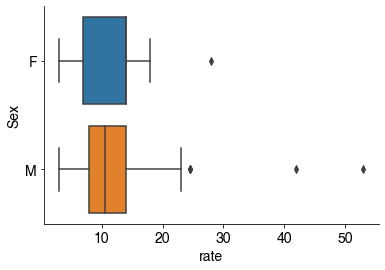

In [10]:
sns.boxplot(y='Sex', x='rate', data=rate_df)

# Baseline viral load at First PCR+

In [11]:
first_data = data.query('final=="First"')
print('%i/%i first' % (first_data.shape[0], data.shape[0]))
print('female ct mean', first_data.query('Sex=="F"')['CTavg'].mean())
print('male ct mean', first_data.query('Sex=="M"')['CTavg'].mean())
print('female asymp rate', (first_data.query('Sex=="F"')['is_asymp']=='asymp').mean())
print('male asymp rate', (first_data.query('Sex=="M"')['is_asymp']=='asymp').mean())

first_data

1161/16985 first
female ct mean 26.2845284237726
male ct mean 24.889743336623887
female asymp rate 0.6461538461538462
male asymp rate 0.7672162948593598


,sid,pid,RNAseq_plate,final,Sex,Age,tp,dayssinceinfect,CTavg,virus_subCL,T0_date,Symptom,samp_date,samp_month,is_asymp,is_lab24
sid,,,,,,,,,,,,,,,,
20_0149-T42,20_0149-T42,149,NaN,First,M,19.0,42,42,29.957500,NaN,2020-05-11,asymp,2020-06-22,2020-06,asymp,True
20_0152-T53,20_0152-T53,152,P10,First,M,19.0,53,53,35.025000,NaN,2020-05-11,asymp,2020-07-03,2020-07,asymp,True
20_0155-T42,20_0155-T42,155,NaN,First,M,22.0,42,42,25.643333,P1A,2020-05-11,asymp,2020-06-22,2020-06,asymp,True
20_0156-T42,20_0156-T42,156,NaN,First,M,22.0,42,42,23.715000,P1A,2020-05-11,asymp,2020-06-22,2020-06,asymp,True
20_0157-T42,20_0157-T42,157,P7,First,M,19.0,42,42,25.736667,NaN,2020-05-11,rn_nose;throat;cough;sob;taste,2020-06-22,2020-06,symp,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20_3468-T56,20_3468-T56,3468,NaN,First,F,20.0,56,56,33.390000,NaN,2020-09-02,asymp,2020-10-28,2020-10,asymp,False
20_3471-T42,20_3471-T42,3471,NaN,First,F,21.0,42,42,15.283333,NaN,2020-09-02,asymp,2020-10-14,2020-10,asymp,False
20_3472-T42,20_3472-T42,3472,NaN,First,F,21.0,42,42,16.461667,P4,2020-09-02,asymp,2020-10-14,2020-10,asymp,False


In [12]:
# initial first_data
print(first_data.groupby('samp_month').size())

# merge small groups: May -> June
first_data['samp_month'].replace({'2020-05': '2020-06'}, inplace=True)
print(first_data.groupby('samp_month').size())
sorted(first_data['samp_month'].unique())

samp_month
2020-06    116
2020-07    367
2020-08    297
2020-09    334
2020-10     47
dtype: int64
samp_month
2020-06    116
2020-07    367
2020-08    297
2020-09    334
2020-10     47
dtype: int64


/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


['2020-06', '2020-07', '2020-08', '2020-09', '2020-10']

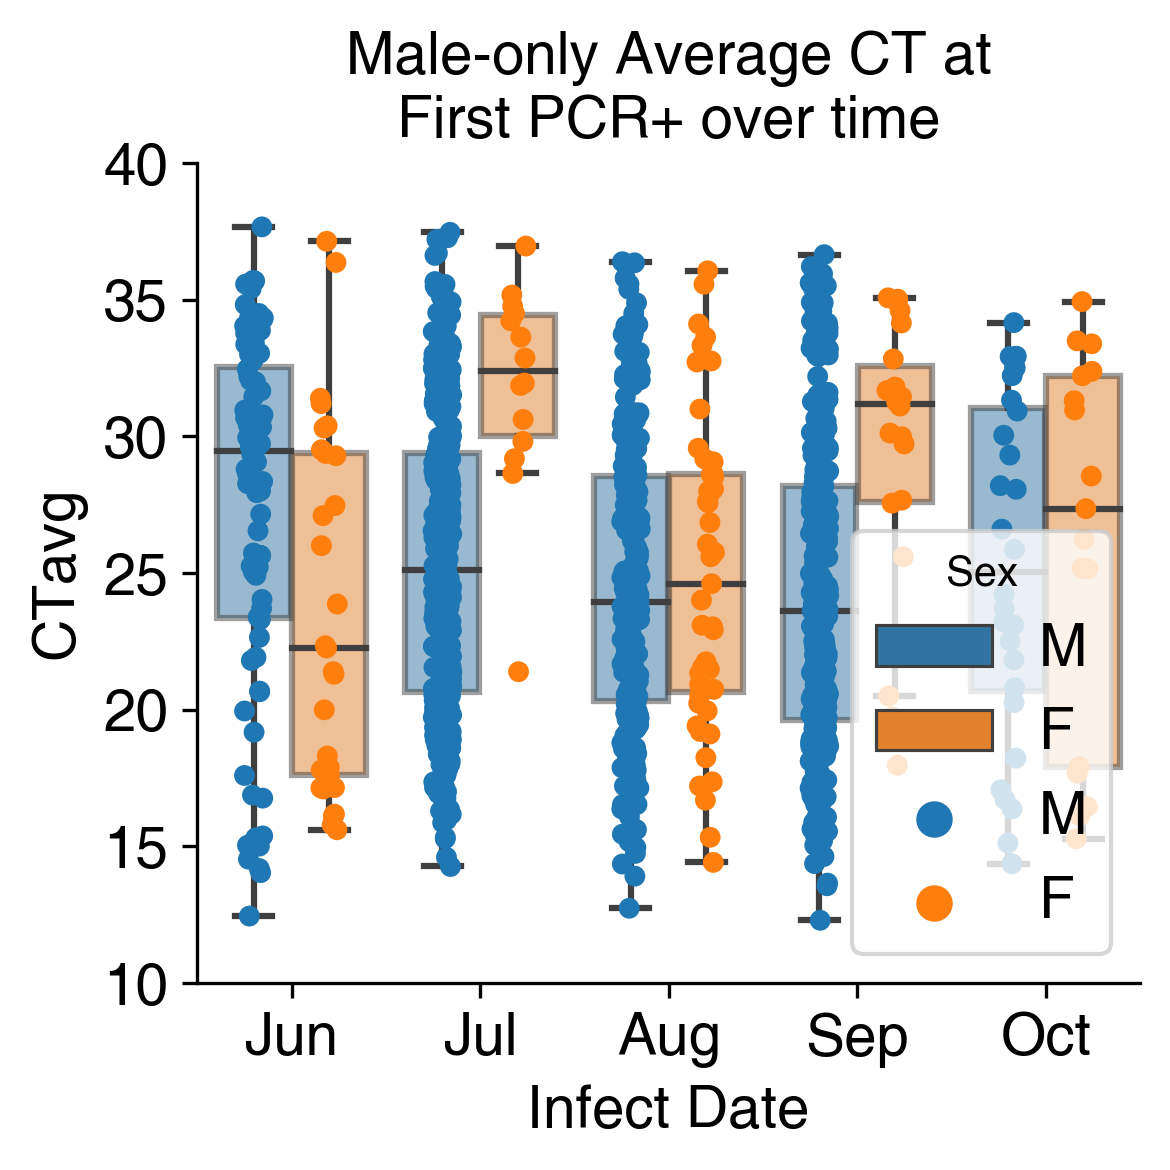

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=300)
#ax = data.query('Sex=="M" and final=="First"').groupby(pd.Grouper(freq='1M',key='samp_date')).mean().unstack(0).fillna(0)['CTavg'].plot()
#ax.set_ylim(20, 35)
sns.boxplot(
    x='samp_month',
    y='CTavg',
    hue='Sex',
    showfliers=False,
    boxprops=dict(alpha=0.5),    
    order=sorted(first_data['samp_month'].unique()),
    data=first_data,
    ax=ax
)
sns.stripplot(
    x='samp_month',
    y='CTavg',
    hue='Sex',
    dodge=True,
    order=sorted(first_data['samp_month'].unique()),
    data=first_data,
    ax=ax
)
ax.set_ylim(10, 40)
ax.set_ylabel('CTavg')
ax.set_xlabel('Infect Date')
ax.set_title('Male-only Average CT at\nFirst PCR+ over time')
#plt.xticks(rotation = 45)
ax.set_xticklabels(['Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
fig.tight_layout()
fig.savefig('%s/03-male_first_ct.pdf' % WD)

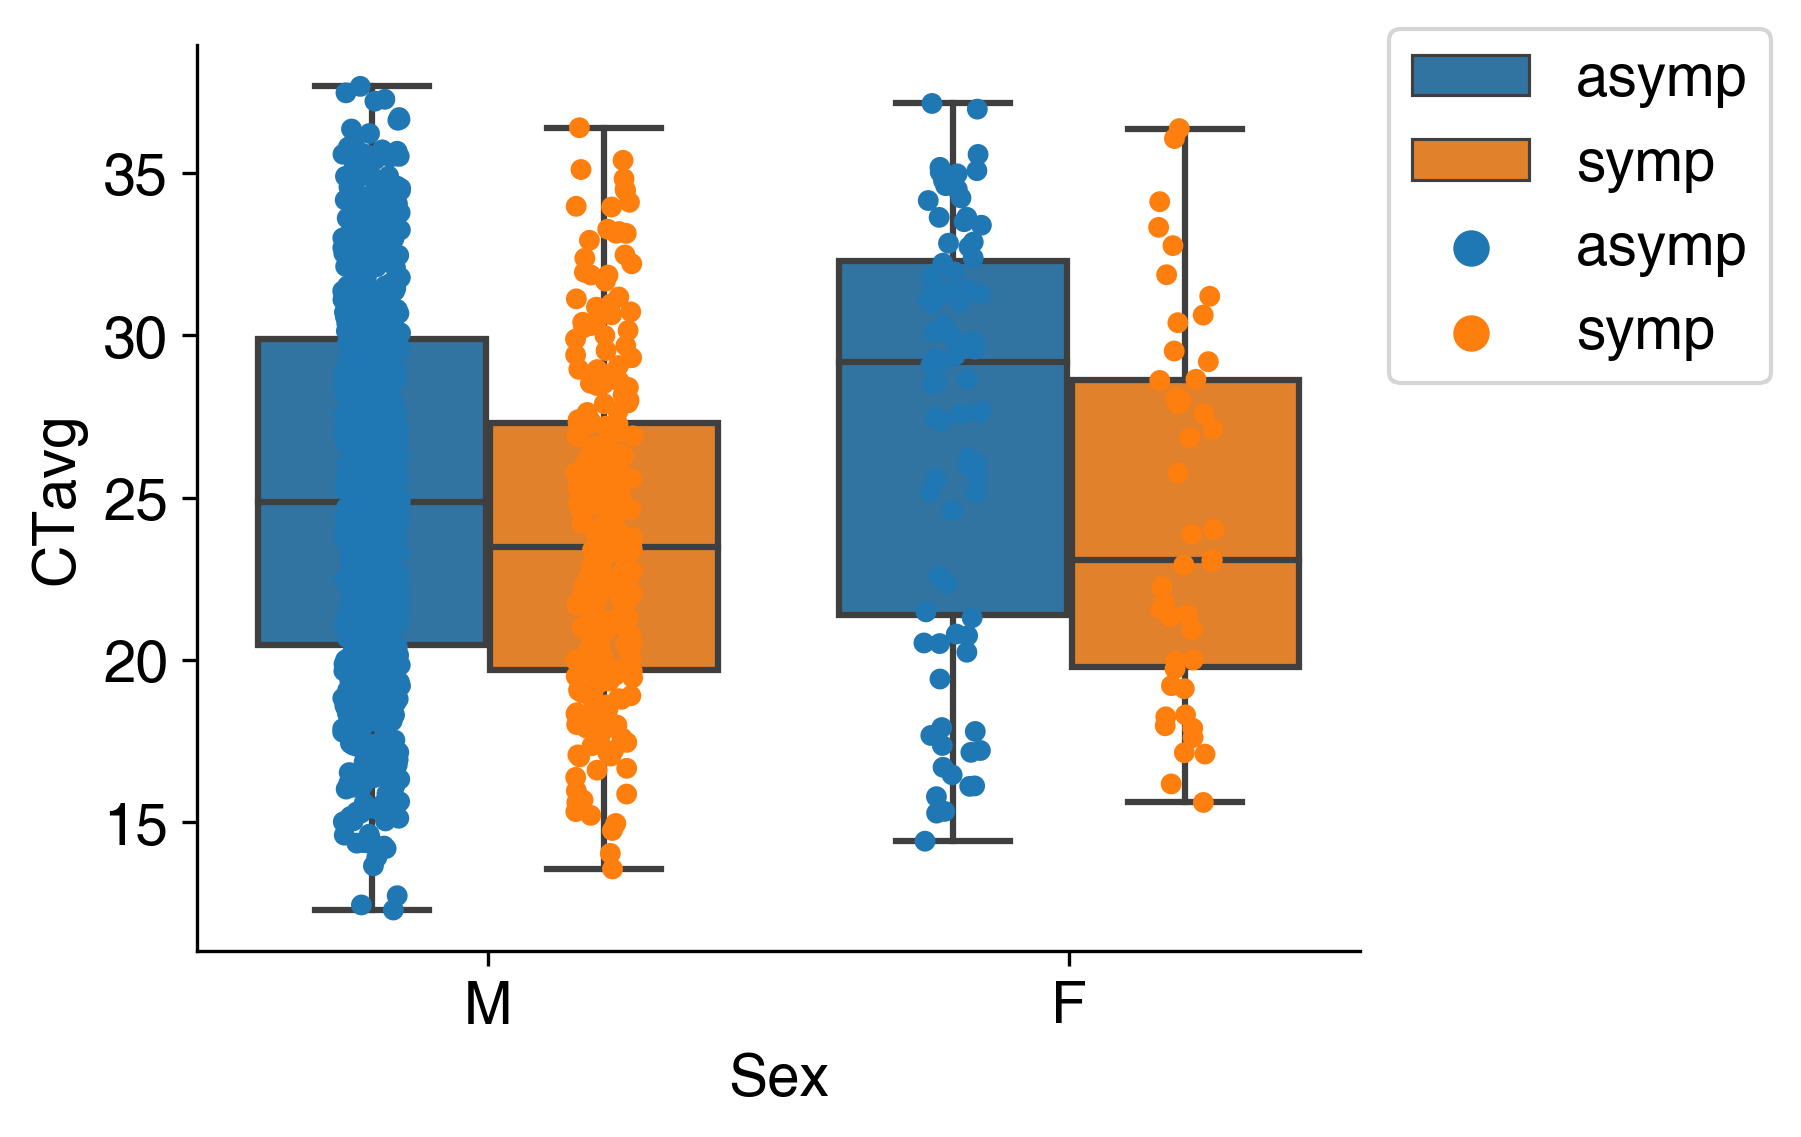

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=300)
sns.boxplot(
    hue='is_asymp',
    y='CTavg',
    x='Sex',
    data=first_data,
    ax=ax
)

sns.stripplot(
    hue='is_asymp',
    y='CTavg',
    x='Sex',
    dodge=True,
    data=first_data,
    ax=ax
)

ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))

In [15]:
# test for sex
ss.mannwhitneyu(
    first_data.query('Sex=="M"')['CTavg'].dropna(),
    first_data.query('Sex=="F"')['CTavg'].dropna()
)

MannwhitneyuResult(statistic=56584.5, pvalue=0.006548310931090828)

In [16]:
# get CI
smf.ols('CTavg~Sex', first_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  CTavg   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.810
Date:                Wed, 25 Aug 2021   Prob (F-statistic):            0.00918
Time:                        19:24:09   Log-Likelihood:                -3610.5
No. Observations:                1142   AIC:                             7225.
Df Residuals:                    1140   BIC:                             7235.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.2845      0.503     52.216      0.000      25.297      27.272
Sex[T.M]      -1.3948      0.534     -2.610      0.009      -2.443      -0.346
==============================================================================
Omnibus:                      199.394   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.078
Skew:                           0.088   Prob(JB):                     1.63e-10
Kurtosis:                       2.043   Cond. No.                         5.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

male mean 24.889743336623887 5.633131317705365
female mean 26.2845284237726 6.343309593057069
male pids 1031
female pids 130


/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


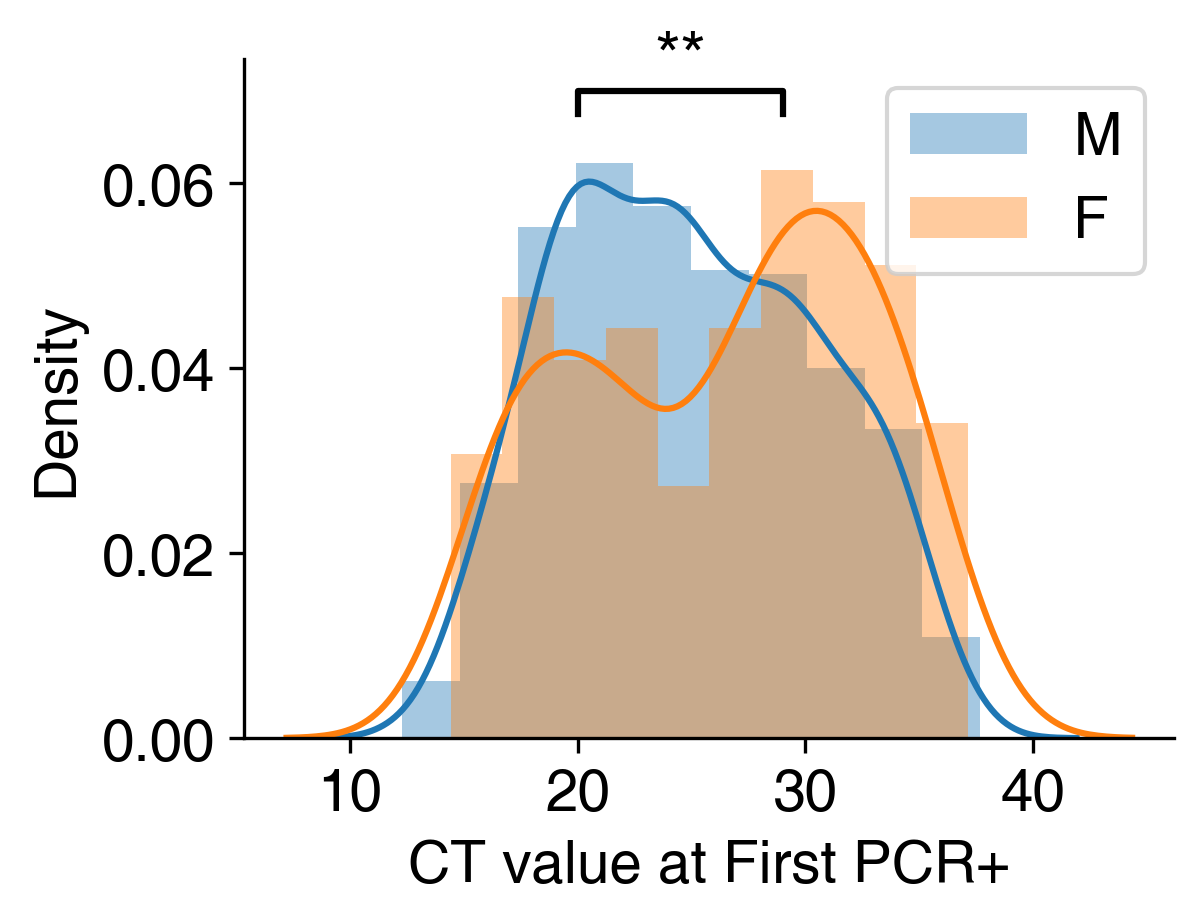

In [17]:
print('male mean', first_data.query('Sex=="M"')['CTavg'].mean(), first_data.query('Sex=="M"')['CTavg'].std())
print('female mean', first_data.query('Sex=="F"')['CTavg'].mean(), first_data.query('Sex=="F"')['CTavg'].std())
print('male pids', len(first_data.query('Sex=="M"')['pid'].unique()))
print('female pids', len(first_data.query('Sex=="F"')['pid'].unique()))


fig, ax = plt.subplots(figsize=(4,3), dpi=300)

sns.distplot(
    first_data.query('Sex=="M"')['CTavg'],
    label='M',
    bins=10,
    ax=ax
)
sns.distplot(
    first_data.query('Sex=="F"')['CTavg'],
    label='F',
    bins=10,
    ax=ax
)
#ax.set_xticklabels([])
#ax.set_xlabel('')
#ax.set_yticklabels([0, '', '', 0.06])
ax.legend()
ax.set_xlabel('CT value at First PCR+')

ax.plot([20, 20, 
         29, 29], [0.0675, 0.07, 0.07, 0.0675], lw=1.5, c='black')
ax.text(24.5, 0.07, '**', ha='center', va='bottom', color='black', fontsize=16)

#fig.tight_layout()
fig.savefig('%s/06-CTfirst_Distr-NoBars.pdf' % WD)



male mean 24.889743336623887
female mean 26.2845284237726


/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


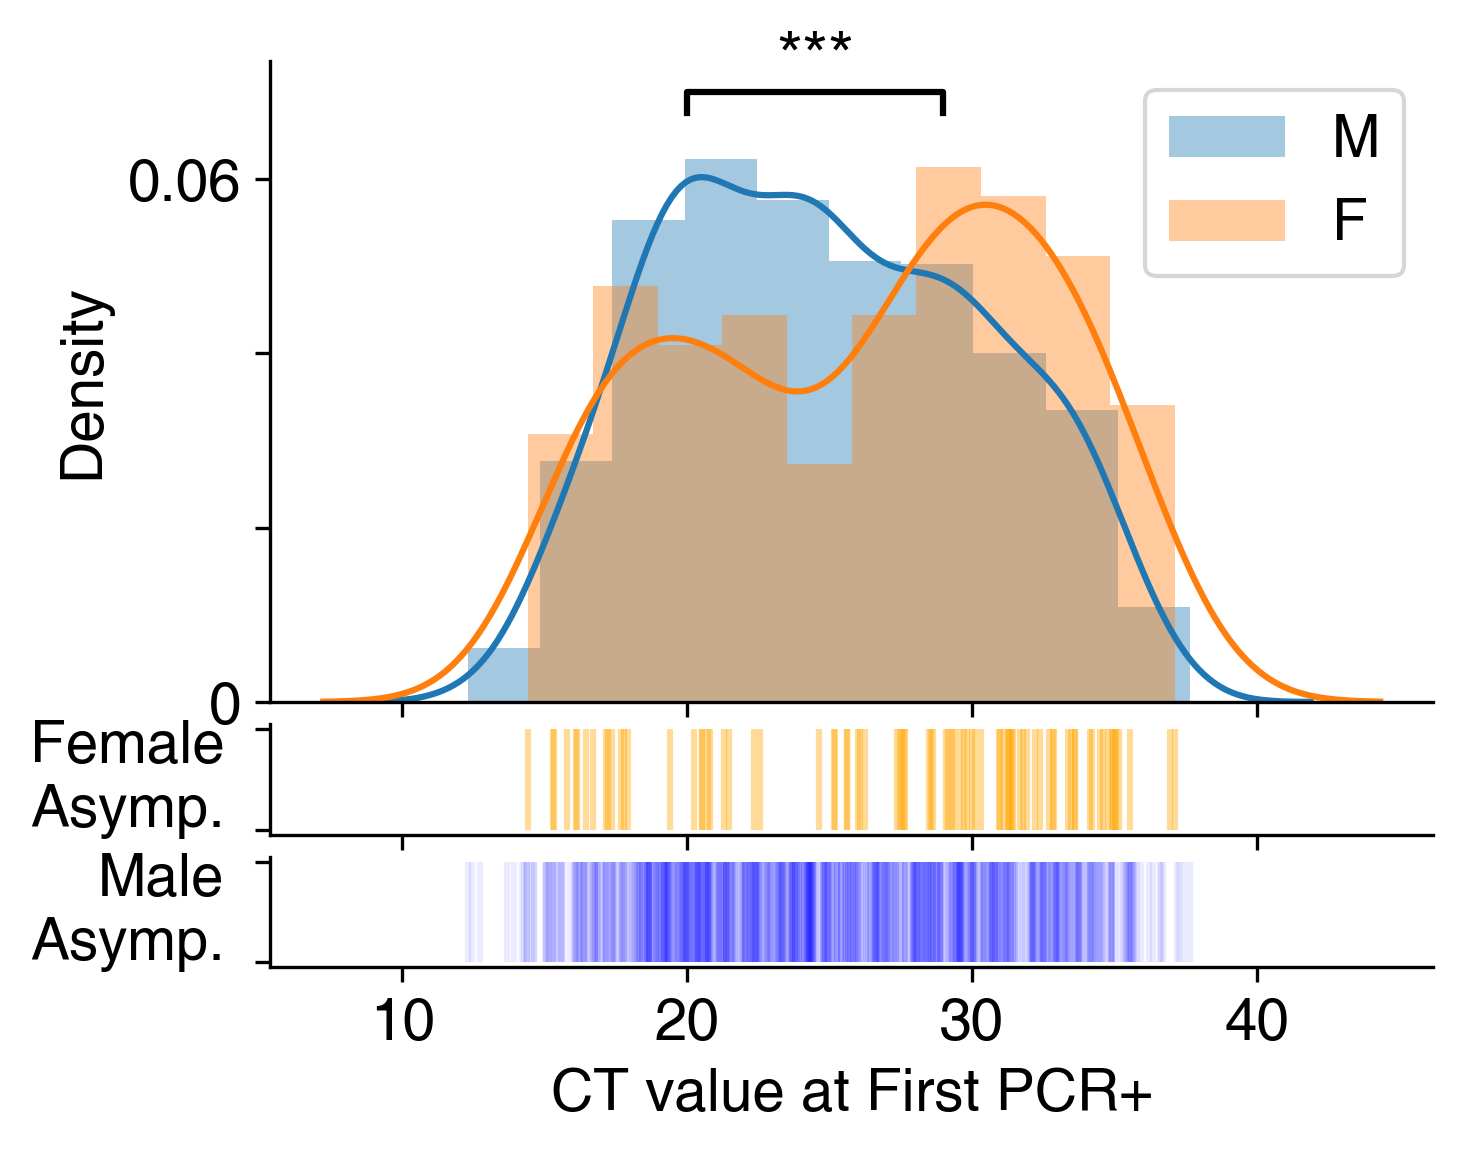

In [18]:
print('male mean', first_data.query('Sex=="M"')['CTavg'].mean())
print('female mean', first_data.query('Sex=="F"')['CTavg'].mean())

fig = plt.figure(figsize=(5,4), dpi=300)
ax = plt.subplot2grid((7,1), (0,0), rowspan=5)
sns.distplot(
    first_data.query('Sex=="M"')['CTavg'],
    label='M',
    bins=10,
    ax=ax
)
sns.distplot(
    first_data.query('Sex=="F"')['CTavg'],
    label='F',
    bins=10,
    ax=ax
)
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_yticklabels([0, '', '', 0.06])
ax.legend()

ax_f = plt.subplot2grid((7,1), (5,0), rowspan=1)
ax_f.vlines(x=first_data.query('Sex=="F" and is_asymp=="asymp"')['CTavg'], ymin=0, ymax=1, alpha=0.4, color='orange')
ax_f.set_xlim(ax.get_xlim())
ax_f.set_xticklabels([])
ax_f.set_yticklabels([])
ax_f.set_ylabel('Female\nAsymp.', verticalalignment='center', horizontalalignment='right', rotation=0)

ax_m = plt.subplot2grid((7,1), (6,0), rowspan=1)
ax_m.vlines(x=first_data.query('Sex=="M" and is_asymp=="asymp"')['CTavg'], ymin=0, ymax=1, alpha=0.08, color='blue')
ax_m.set_xlim(ax.get_xlim())
ax_m.set_yticklabels([])
ax_m.set_ylabel('Male\nAsymp.', verticalalignment='center', horizontalalignment='right', rotation=0)
ax_m.set_xlabel('CT value at First PCR+')

ax.plot([20, 20, 
         29, 29], [0.0675, 0.07, 0.07, 0.0675], lw=1.5, c='black')
ax.text(24.5, 0.07, '***', ha='center', va='bottom', color='black', fontsize=16)

#fig.tight_layout()
fig.savefig('%s/06-CTfirst_Distr.pdf' % WD)

In [19]:
first_data[['Sex', 'is_lab24', 'CTavg']].groupby(['Sex', 'is_lab24']).mean()

CTavg
Sex is_lab24           
F   False     27.984402
    True      25.547917
M   False     24.195121
    True      25.236027

In [20]:
first_data[['Sex', 'is_lab24', 'CTavg']].groupby(['Sex', 'is_lab24']).size()

Sex  is_lab24
F    False        39
     True         91
M    False       349
     True        682
dtype: int64

In [21]:
# STATS TESTING
anova_sumstats = pd.DataFrame(columns=['cond', 'n.female', 'n.male', 'ct.female', 'ct.male', 'pvalue'])

In [22]:
# Does Sex have an effect on First PCR+ CT, after controlling for month? -- YES
print(first_data.groupby('Sex').agg('mean'))

anova_mod0 = smf.ols('CTavg ~ C(samp_month) + is_lab24', data=first_data).fit()
anova_mod1 = smf.ols('CTavg ~ Sex + C(samp_month) + is_lab24', data=first_data).fit()

print(anova_mod1.summary())

table = anova_lm(anova_mod0, anova_mod1)

anova_sumstats = anova_sumstats.append(
    {
        'cond': 'total',
        'n.female': first_data.query('Sex=="F"').shape[0],
        'n.male': first_data.query('Sex=="M"').shape[0],
        'ct.female': first_data.query('Sex=="F"')['CTavg'].mean(),
        'ct.male': first_data.query('Sex=="M"')['CTavg'].mean(),
        'pvalue': table.iloc[1]['Pr(>F)']

    },
    ignore_index=True
)
table

             pid        Age         tp  dayssinceinfect      CTavg  is_lab24
Sex                                                                         
F    1499.369231  19.138462  40.730769        40.730769  26.284528  0.700000
M    1574.461688  19.069835  37.280310        37.280310  24.889743  0.661494
                            OLS Regression Results                            
Dep. Variable:                  CTavg   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.614
Date:                Wed, 25 Aug 2021   Prob (F-statistic):            0.00148
Time:                        19:24:10   Log-Likelihood:                -3603.1
No. Observations:                1142   AIC:                             7220.
Df Residuals:                    1135   BIC:                             7255.
Df Model:                           6                       

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1136.0,36977.446436,0.0,NaN,NaN,NaN
1,1135.0,36783.258575,1.0,194.187861,5.991944,0.014522


In [23]:
# Does Sex have an effect on First PCR+ CT, for asymptomatic cases after controlling for month? -- YES
# *for asymptomatic cases ONLY*

print(first_data.query('is_asymp=="asymp"').groupby('Sex').agg('mean'))
anova_mod0 = smf.ols('CTavg ~ C(samp_month) + is_lab24', data=first_data.query('is_asymp=="asymp"')).fit()
anova_mod1 = smf.ols('CTavg ~ Sex + C(samp_month) + is_lab24', data=first_data.query('is_asymp=="asymp"')).fit()

print(anova_mod1.summary())

table = anova_lm(anova_mod0, anova_mod1)

anova_sumstats = anova_sumstats.append(
    {
        'cond': 'asymp',
        'n.female': first_data.query('is_asymp=="asymp" and Sex=="F"').shape[0],
        'n.male': first_data.query('is_asymp=="asymp" and Sex=="M"').shape[0],
        'ct.female': first_data.query('is_asymp=="asymp" and Sex=="F"')['CTavg'].mean(),
        'ct.male': first_data.query('is_asymp=="asymp" and Sex=="M"')['CTavg'].mean(),
        'pvalue': table.iloc[1]['Pr(>F)']

    },
    ignore_index=True
)
table

             pid        Age         tp  dayssinceinfect      CTavg  is_lab24
Sex                                                                         
F    1735.071429  19.023810  42.904762        42.904762  27.290562  0.559524
M    1614.474083  19.096081  36.123894        36.123894  25.237934  0.637168
                            OLS Regression Results                            
Dep. Variable:                  CTavg   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     4.500
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           0.000169
Time:                        19:24:10   Log-Likelihood:                -2719.1
No. Observations:                 858   AIC:                             5452.
Df Residuals:                     851   BIC:                             5485.
Df Model:                           6                       

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,852.0,28743.861156,0.0,NaN,NaN,NaN
1,851.0,28422.498906,1.0,321.36225,9.621929,0.001986


In [24]:
# Does Sex have an effect on First PCR+ CT, for symptomatic cases after controlling for month? -- NO
# *for symptomatic cases ONLY*

print(first_data.query('is_asymp=="symp"').groupby('Sex').agg('mean'))

anova_mod0 = smf.ols('CTavg ~ C(samp_month) + is_lab24', data=first_data.query('is_asymp=="symp"')).fit()
anova_mod1 = smf.ols('CTavg ~ Sex + C(samp_month) + is_lab24', data=first_data.query('is_asymp=="symp"')).fit()

print(anova_mod1.summary())

table = anova_lm(anova_mod0, anova_mod1)

anova_sumstats = anova_sumstats.append(
    {
        'cond': 'symp',
        'n.female': first_data.query('is_asymp=="symp" and Sex=="F"').shape[0],
        'n.male': first_data.query('is_asymp=="symp" and Sex=="M"').shape[0],
        'ct.female': first_data.query('is_asymp=="symp" and Sex=="F"')['CTavg'].mean(),
        'ct.male': first_data.query('is_asymp=="symp" and Sex=="M"')['CTavg'].mean(),
        'pvalue': table.iloc[1]['Pr(>F)']

    },
    ignore_index=True
)
table

             pid        Age         tp  dayssinceinfect      CTavg  is_lab24
Sex                                                                         
F    1068.956522  19.347826  36.760870        36.760870  24.469293  0.956522
M    1442.587500  18.983333  41.091667        41.091667  23.755928  0.741667
                            OLS Regression Results                            
Dep. Variable:                  CTavg   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.5902
Date:                Wed, 25 Aug 2021   Prob (F-statistic):              0.738
Time:                        19:24:10   Log-Likelihood:                -868.65
No. Observations:                 284   AIC:                             1751.
Df Residuals:                     277   BIC:                             1777.
Df Model:                           6                       

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,278.0,7554.764223,0.0,NaN,NaN,NaN
1,277.0,7542.731089,1.0,12.033134,0.441906,0.506757


In [25]:
anova_sumstats

,cond,n.female,n.male,ct.female,ct.male,pvalue
0,total,130,1031,26.284528,24.889743,0.014522
1,asymp,84,791,27.290562,25.237934,0.001986
2,symp,46,240,24.469293,23.755928,0.506757


In [26]:
print("FINISH:", datetime.now())

FINISH: 2021-08-25 19:24:10.870965
